In [7]:
import pandas as pd
import glob
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load basket data
basket_df = pd.read_csv("data/company_basket.csv", sep=";")

# Load all existing Sweden stock data files
sweden_stock_files = glob.glob("data/Sweden_*.txt")

stock_data = pd.concat([pd.read_csv(f, sep=";") for f in sweden_stock_files])

# Ensure all companies have an industry and sector
stock_data["industry_name"] = stock_data["industry_name"].fillna("Unknown")
stock_data["economic_sector_name"] = stock_data["economic_sector_name"].fillna("Unknown")

# One-hot encode industry_name and economic_sector_name
industry_encoded = pd.get_dummies(stock_data[['company_name', 'industry_name']], columns=['industry_name'])
sector_encoded = pd.get_dummies(stock_data[['company_name', 'economic_sector_name']], columns=['economic_sector_name'])

# Merge one-hot encoded data to create stock_features
stock_features = pd.concat([industry_encoded, sector_encoded.drop("company_name", axis=1)], axis=1)
# Group by company_name to consolidate multiple entries per company
stock_features = stock_features.groupby("company_name").max().astype(int).reset_index()

In [8]:
stock_features.head()

,company_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,"industry_name_Appliances, Tools & Housewares",...,economic_sector_name_Basic Materials,economic_sector_name_Consumer Cyclicals,economic_sector_name_Consumer Non-Cyclicals,economic_sector_name_Energy,economic_sector_name_Financials,economic_sector_name_Healthcare,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Utilities
0,24SevenOffice Scandinavia AB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2cureX AB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4C Group AB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,AAC Clyde Space AB,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,AAK AB (publ),0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [10]:
def create_basket_features(basket_df, stock_features):
    # Convert shares to decimals
    basket_df['company_share'] = basket_df['company_share'] / 100.0
    
    # Get feature columns
    feature_cols = stock_features.columns.drop('company_name')
    
    # Merge and calculate weighted features
    merged = pd.merge(basket_df, stock_features, on='company_name')
    for col in feature_cols:
        merged[col] = merged[col] * merged['company_share']
    
    # Sum features for each basket
    basket_features = merged.groupby('basket_name')[feature_cols].sum()
    
    return basket_features.reset_index()

# Create basket features
basket_features = create_basket_features(basket_df, stock_features)

In [11]:
basket_features.head()

,basket_name,industry_name_Advanced Medical Equipment & Technology,industry_name_Advertising & Marketing,industry_name_Aerospace & Defense,industry_name_Agricultural Chemicals,industry_name_Airlines,industry_name_Aluminum,industry_name_Apparel & Accessories,industry_name_Apparel & Accessories Retailers,"industry_name_Appliances, Tools & Housewares",...,economic_sector_name_Basic Materials,economic_sector_name_Consumer Cyclicals,economic_sector_name_Consumer Non-Cyclicals,economic_sector_name_Energy,economic_sector_name_Financials,economic_sector_name_Healthcare,economic_sector_name_Industrials,economic_sector_name_Real Estate,economic_sector_name_Technology,economic_sector_name_Utilities
0,Aluminium,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,...,0.066667,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,BIG INDEX Global,0.0,0.0,0.004657,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000995,0.004657,0.0,0.0,0.0
2,Biotech EBITDA>0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.005405,0.000000,0.0,0.0,0.0
3,Biotech MCAP >30 m and < 80 m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.020588,0.000000,0.0,0.0,0.0
4,Broadcasting companiess,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [13]:
# Compute cosine similarity matrix (n_basket, n_basket)
similarity_matrix = cosine_similarity(basket_features.iloc[:, 1:].values)

# Get the basket index mapping from unique baskets
basket_to_idx = {name: idx for idx, name in enumerate(basket_features['basket_name'])}

# Function to get similar baskets
def get_similar_baskets(basket_name, similarity_matrix, n=10): 
    if basket_name not in basket_features['basket_name'].values:
        print("\nAvailable baskets:")
        print(sorted(basket_features['basket_name'].unique()))
        raise ValueError(f"\nBasket '{basket_name}' not found in the data")

    # Get index for the target basket
    target_idx = basket_to_idx[basket_name]
    
    similarity_scores = list(enumerate(similarity_matrix[target_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    # Get basket names corresponding to top similar indices
    similar_baskets = [list(basket_to_idx.keys())[i[0]] for i in similarity_scores]

    return similar_baskets

try:
    # Try with a basket name that exists in the data
    similar = get_similar_baskets("BIG INDEX Global", similarity_matrix, n=10)
    print("\nSimilar baskets to 'BIG INDEX Global':")
    print(similar)
except ValueError as e:
    print(e)


Similar baskets to 'BIG INDEX Global':
['MooseBit - best case', 'High profits with growth', 'European airlines', 'Growth Rockets', 'MooseBit explosion', 'Nordic Construction Companies', 'Sustainable electric equipment', 'Strong value growth Europe', 'Swedish weaked valued', 'French Energy']


Found rows: 0
Number of unique baskets: 197
Number of baskets in features: 85
Number of baskets in mapping: 85
Missing companies:
                         basket_name          company_name  company_share
0     a123456789b123456789c123456789     Gaming Realms PLC       0.224743
1     a123456789b123456789c123456789   Intercede Group PLC       0.158302
2     a123456789b123456789c123456789            Jujubee SA       0.006129
4     a123456789b123456789c123456789            Osmozis SA       0.166751
5     a123456789b123456789c123456789        Vigo System SA       0.112004
...                              ...                   ...            ...
3278                          WTF II            Capitea SA       0.012435
3279                          WTF II   Dolphin Drilling AS       0.551787
3280                          WTF II  Energy Solar Tech SA       0.042565
3281                          WTF II       Kibo Energy PLC       0.007097
3282                          WTF II  Live Motion Games 

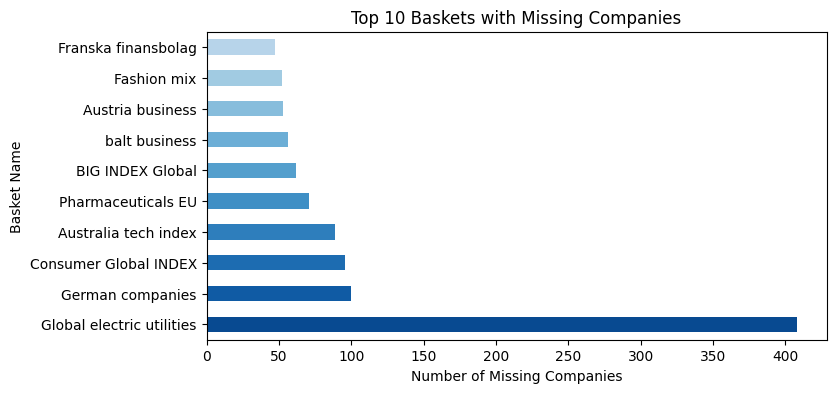

In [14]:
# Debug information
merged = pd.merge(basket_df, stock_features, on='company_name')
merged
wtf_rows = merged[merged['basket_name'] == "WTF II"]
print("Found rows:", len(wtf_rows))

num_baskets = basket_df['basket_name'].nunique()
print(f"Number of unique baskets: {num_baskets}")
print("Number of baskets in features:", len(basket_features))
print("Number of baskets in mapping:", len(basket_to_idx))

# Check companies in basket_df that aren't in stock_features
missing_companies = basket_df[~basket_df['company_name'].isin(stock_features['company_name'])]
print("Missing companies:")
print(missing_companies)

# Check how many companies are lost per basket
lost_companies = missing_companies.groupby('basket_name')['company_name'].count()
lost_companies = lost_companies.sort_values(ascending=False)
n_lost_companies = 10
plt.figure(figsize=(8, 4))
colors = plt.cm.Blues(np.linspace(0.9, 0.3, n_lost_companies))
lost_companies.head(n_lost_companies).plot(kind='barh', color=colors)
plt.title('Top 10 Baskets with Missing Companies')
plt.xlabel('Number of Missing Companies')
plt.ylabel('Basket Name')
print("\nNumber of lost companies per basket:")
print(lost_companies)